<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Distributed_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l -q

     |████████████████████████████████| 82 kB 579 kB/s 
     |████████████████████████████████| 9.9 MB 29.3 MB/s 
     |████████████████████████████████| 11.2 MB 42.0 MB/s 
     |████████████████████████████████| 61 kB 7.2 MB/s 
     |████████████████████████████████| 899 kB 43.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Hybrid Programming

• Imperative programming is easier. When imperative programming is used in Python, the majority of the code is straightforward and easy to write. It is also easier to debug imperative programming code. This is because it is easier to obtain and print all relevant intermediate variable values, or use Pythonʼs built-in debugging tools.

• Symbolic programming is more efficient and easier to port. Symbolic programming makes it easier to optimize the code during compilation, while also having the ability to port the program into a format independent of Python. This allows the program to be run in a non- Python environment, thus avoiding any potential performance issues related to the Python interpreter.

In an effort to leverage the portability and efficiency of symbolic programming, developers considered whether it would be possible to combine the benefits of both programming models. This led to a torchscript that lets users develop and debug using pure imperative programming, while having the ability to convert most programs into symbolic programs to be run when product-level computing performance and deployment are required.

In [3]:
class Benchmark:
  """For measuring running time."""
  def __init__(self, description='Done'):
    self.description = description
    
  def __enter__(self): 
    self.timer = d2l.Timer() 
    return self
  
  def __exit__(self, *args):
    print(f'{self.description}: {self.timer.stop():.4f} sec')

In [7]:
def get_net():
  net = nn.Sequential(nn.Linear(512, 256),nn.ReLU(), 
                      nn.Linear(256, 128), nn.ReLU(), 
                      nn.Linear(128, 2))
  return net
x = torch.randn(size=(1, 512))


In [14]:
net = get_net()
with Benchmark('Without torchscript'):
    for i in range(100000):
      net(x)

Without torchscript: 12.5632 sec


In [15]:
with Benchmark ('Time taken to compile into torchscript'):
  net = torch.jit.script(net)
with Benchmark('With torchscript'):
    for i in range(100000): 
      net(x)

Time taken to compile into torchscript: 0.0225 sec
With torchscript: 9.3899 sec


One of the benefits of compiling the models is that we can serialize (save) the model and its parameters to disk. This allows us to store a model in a manner that is independent of the front-end language of choice. This allows us to deploy trained models to other devices and easily use other front-end programming languages. At the same time the code is often faster than what can be achieved in imperative programming. Let us see the save function in action.

In [16]:
net.save('my_mlp') 
!ls -lh my_mlp*

-rw-r--r-- 1 root root 651K Apr  5 05:48 my_mlp


# Asynchronous Computation

Deep learning frameworks such as MXNet and TensorFlow adopt an asynchronous programming model to improve performance, while PyTorch uses Pythonʼs own scheduler leading to a differ- ent performance trade-off. For PyTorch, by default, GPU operations are asynchronous. When you call a function that uses the GPU, the operations are enqueued to the particular device, but not necessarily executed until later. This allows us to execute more computations in parallel, including operations on the CPU or other GPUs.

In [2]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
# Warmup for GPU computation
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device) 
b = torch.mm(a, a)
with d2l.Benchmark('numpy'): 
  for _ in range(10):
    a = numpy.random.normal(size=(1000, 1000)) 
    b = numpy.dot(a, a)

with d2l.Benchmark('torch'): 
  for _ in range(10):
    a = torch.randn(size=(1000, 1000), device=device) 
    b = torch.mm(a, a)

numpy: 1.1675 sec
torch: 0.0018 sec


The benchmark output via PyTorch is orders of magnitude faster. NumPy dot product is executed on the CPU processor while PyTorch matrix multiplication is executed on GPU and hence the latter is expected to be much faster. But the huge time difference suggests something else must be going on. By default, GPU operations are asynchronous in PyTorch. Forcing PyTorch to finish all computation prior to returning shows what happened previously: computation is being executed by the backend while the frontend returns control to Python.

In [19]:
with d2l.Benchmark(): 
  for _ in range(10):
    a = torch.randn(size=(1000, 1000), device=device)
    b = torch.mm(a, a) 
  torch.cuda.synchronize(device)

Done: 0.0152 sec


Regardless of the frontend programming language used, the execution of PyTorch programs occurs primarily in the backend of C++ implementations. Operations issued by the frontend language are passed on to the backend for execution. The backend manages its own threads that continuously collect and execute queued tasks. Note that for this to work the backend must be able to keep track of the dependencies between various steps in the computational graph. Hence, it is not possible to parallelize operations that depend on each other.

# Automatic Parallelism 
###(Won't run in Colab since we need multiple GPUs)

Using a computational graph, the system is aware of all the dependencies, and can selectively execute multiple non-interdependent tasks in parallel to improve speed. For instance if we initialize two variables independently,  the system can choose to execute them in parallel.

Typically, a single operator will use all the computational resources on all CPUs or on a single GPU. For example, the dot operator will use all cores (and threads) on all CPUs, even if there are multiple CPU processors on a single machine. The same applies to a single GPU. 

While parallelization is typically most relevant between multiple GPUs, adding the local CPU will increase performance slightly. For example, see (Hadjis et al., 2016) that focuses on training computer vision models combining a GPU and a CPU. With the convenience of an automatically parallelizing framework we can accomplish the same goal in a few lines of Python code. More broadly, our discussion of automatic parallel computation focuses on parallel computation using both CPUs and GPUs, as well as the parallelization of computation and communication.

In [ ]:
devices = d2l.try_all_gpus() 
def run(x):
  return [x.mm(x) for _ in range(50)]
x_gpu1 = torch.rand(size=(4000, 4000), device=devices[0]) 
x_gpu2 = torch.rand(size=(4000, 4000), device=devices[1])

In [ ]:
run(x_gpu1)
run(x_gpu2) # Warm-up all devices 
torch.cuda.synchronize(devices[0]) 
torch.cuda.synchronize(devices[1])

with d2l.Benchmark('GPU1 time'): 
  run(x_gpu1)
  torch.cuda.synchronize(devices[0])
with d2l.Benchmark('GPU2 time'): 
  run(x_gpu2)
  torch.cuda.synchronize(devices[1])

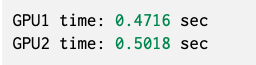

If we remove the synchronize statement between both tasks the system is free to parallelize computation on both devices automatically.

In [ ]:
with d2l.Benchmark('GPU1 & GPU2'):
  run(x_gpu1)
  run(x_gpu2) 
  torch.cuda.synchronize()

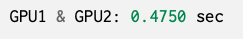

In many cases we need to move data between different devices, say between the CPU and GPU, or between different GPUs. For instance, this occurs when we want to perform distributed optimization where we need to aggregate the gradients over multiple accelerator cards. Let us simulate this by computing on the GPU and then copying the results back to the CPU.

In [21]:
def run(x):
  return [x.mm(x) for _ in range(50)]

def copy_to_cpu(x, non_blocking=False):
  return [y.to('cpu', non_blocking=non_blocking) for y in x]

with d2l.Benchmark('Run on GPU1'): 
  y = run(torch.rand(size=(4000, 4000), device=device))
  torch.cuda.synchronize()

with d2l.Benchmark('Copy to CPU'): 
  y_cpu = copy_to_cpu(y) 
  torch.cuda.synchronize()

Run on GPU1: 2.8286 sec
Copy to CPU: 2.0094 sec


This is somewhat inefficient. Note that we could already start copying parts of y to the CPU while the remainder of the list is still being computed. This situation occurs, e.g., when we compute the (backprop) gradient on a minibatch. The gradients of some of the parameters will be avail- able earlier than that of others. Hence it works to our advantage to start using PCI-Express bus bandwidth while the GPU is still running. In PyTorch, several functions such as to() and copy_() admit an explicit non_blocking argument, which lets the caller bypass synchronization when it is unnecessary. Setting non_blocking=True allows us to simulate this scenario.


The total time required for both operations is (as expected) less than the sum of their parts. Note that this task is different from parallel computation as it uses a different resource: the bus between the CPU and GPUs. In fact, we could compute on both devices and communicate, all at the same time. As noted above, there is a dependency between computation and communication: y[i] must be computed before it can be copied to the CPU. Fortunately, the system can copy y[i-1] while computing y[i] to reduce the total running time.

In [23]:
with d2l.Benchmark('Run on GPU1 and copy to CPU simultaneously'): 
  y = run(torch.rand(size=(4000, 4000), device=device))
  y_cpu = copy_to_cpu(y, True) 
  torch.cuda.synchronize()

Run on GPU1 and copy to CPU simultaneously: 3.5583 sec


# Multi-GPU Training

###(Won't run in Colab since we need multiple GPUs)

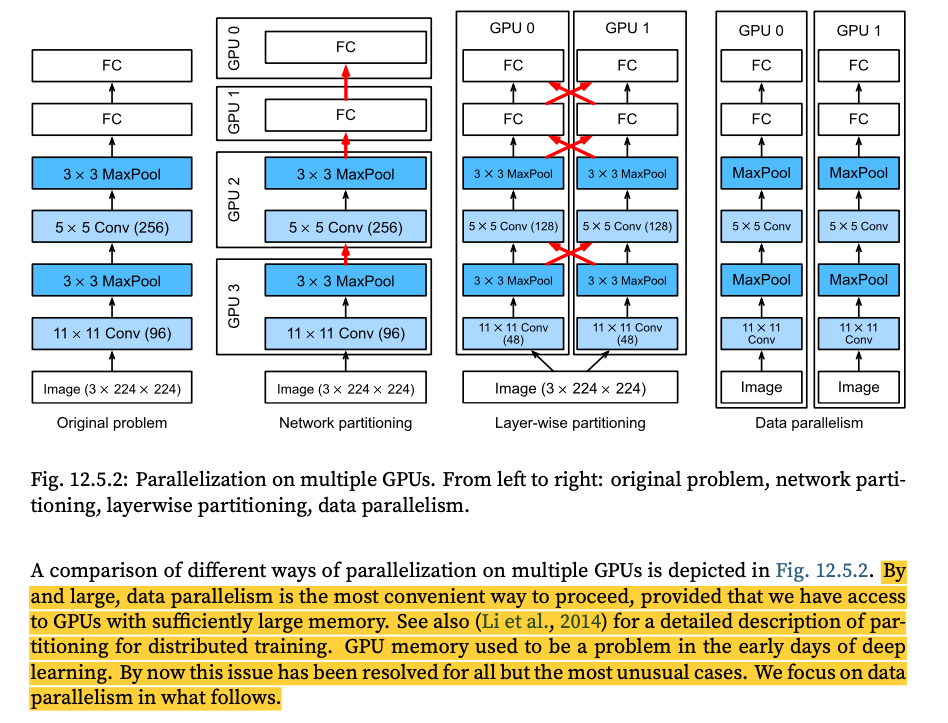

# Method

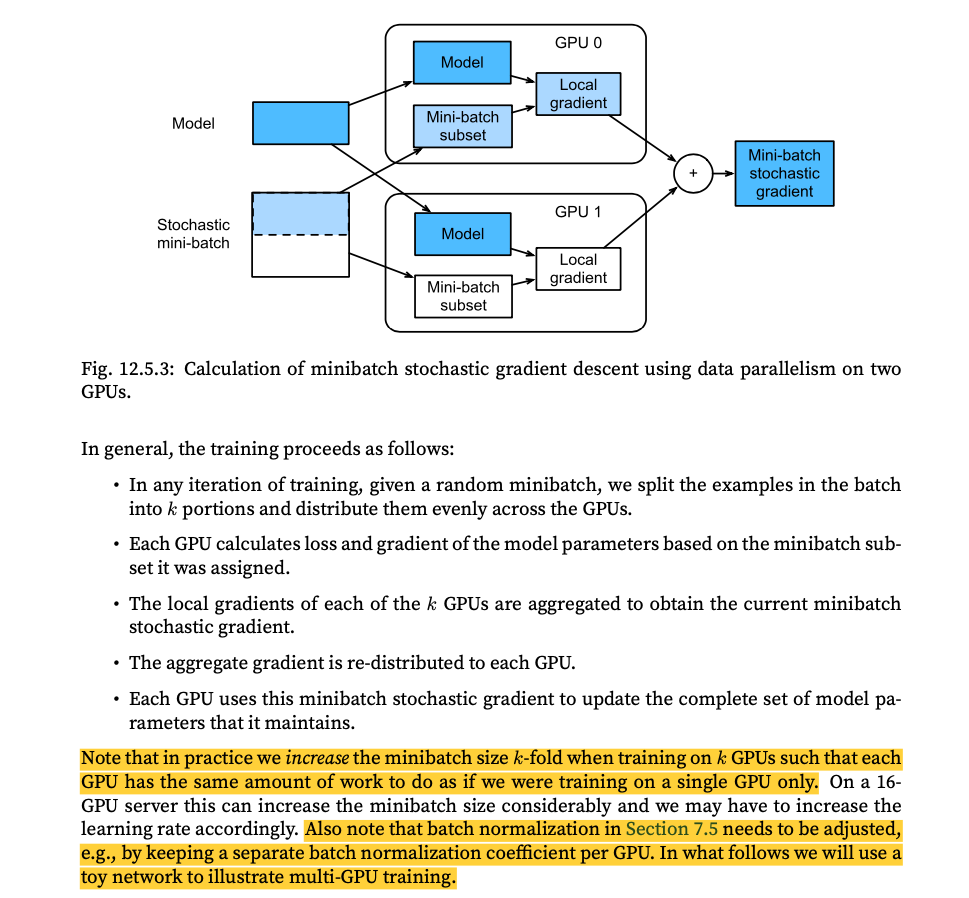

In [4]:
from torch.nn import functional as F
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale 
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale 
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]
# Define the model
def lenet(X, params):
  h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1]) 
  h1_activation = F.relu(h1_conv)
  h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2)) 
  h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3]) 
  h2_activation = F.relu(h2_conv)
  h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2)) 
  h2 = h2.reshape(h2.shape[0], -1)
  h3_linear = torch.mm(h2, params[4]) + params[5]
  h3 = F.relu(h3_linear)
  y_hat = torch.mm(h3, params[6]) + params[7]
  return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

In [5]:
def put_params_on_device(params, device):
  ''' Take params and put them on a specific device and enable autograd for them on that device'''
  new_params = [p.to(device) for p in params] 
  for p in new_params:
    p.requires_grad_() 
  return new_params

In [7]:
def aggregate_and_distribute(data):
  ''' Take params and put them on a specific device and enable autograd for them on that device'''
  for i in range(1, len(data)):
    data[0][:] += data[i].to(data[0].device) #Add data on device 0
  for i in range(1, len(data)):
    data[i][:] = data[0].to(data[i].device) #Distribute aggregated data on all devices

In [13]:
def split_batch(X, y, devices):
  """Split `X` and `y` into multiple devices.""" 
  assert X.shape[0] == y.shape[0]
  return (nn.parallel.scatter(X, devices),nn.parallel.scatter(y, devices)) #Splits rows not columns

In [9]:
def train_batch(X,y,params, devices, lr):
  ''' params is a num_devices X params_per_device matrix'''
  X_shards, y_shards = split_batch(X, y, devices)
  # Loss is calculated separately on each GPU
  ls = [loss(lenet(X_shard, device_W), y_shard).sum() for X_shard, y_shard, device_W in zip( X_shards, y_shards, params)]

  for l in ls: # Backpropagation is performed separately on each GPU 
    l.backward()

  # Sum all gradients from each GPU and broadcast them to all GPUs
  with torch.no_grad():
    for i in range(len(params[0])):
      aggregate_and_distribute([params[c][i].grad for c in range(len(devices))])

  # The model parameters are updated separately on each GPU
  for param_group in params:
    d2l.sgd(param_group, lr, X.shape[0]) # Here, we use a full-size batch



In [14]:
def train(num_gpus, batch_size, lr):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) 
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]
  # Copy model parameters to `num_gpus` GPUs
  device_params = [put_params_on_device(params, d) for d in devices] 
  num_epochs = 10
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs]) 
  timer = d2l.Timer()

  for epoch in range(num_epochs): 
    timer.start()
    for X, y in train_iter:
      # Perform multi-GPU training for a single minibatch 
      train_batch(X, y, device_params, devices, lr) 
      torch.cuda.synchronize()
    timer.stop()
    # Evaluate the model on GPU 0
    animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(lambda x: lenet(x, device_params[0]), test_iter, devices[0]),)) 
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch 'f'on {str(devices)}')

test acc: 0.84, 7.7 sec/epoch on [device(type='cuda', index=0)]


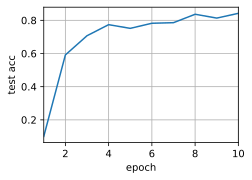

In [15]:
train(num_gpus=1, batch_size=256, lr=0.2)

# Concise Implementation of Distributed Training



In [17]:
def resnet18(num_classes, in_channels=1):
  """A slightly modified ResNet-18 model."""
  def resnet_block(in_channels, out_channels, num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block: 
        blk.append(d2l.Residual(in_channels, out_channels,use_1x1conv=True, strides=2))
      else: 
        blk.append(d2l.Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

  # This model uses a smaller convolution kernel, stride, and padding and # removes the maximum pooling layer
  net = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64),nn.ReLU())
  net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True)) 
  net.add_module("resnet_block2", resnet_block(64, 128, 2)) 
  net.add_module("resnet_block3", resnet_block(128, 256, 2)) 
  net.add_module("resnet_block4", resnet_block(256, 512, 2)) 
  net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1))) 
  net.add_module("fc", nn.Sequential(nn.Flatten(),nn.Linear(512, num_classes)))
  return net

net = resnet18(10)
# Get a list of GPUs
devices = d2l.try_all_gpus()

In [18]:
def train(net, num_gpus, batch_size, lr):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) 
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]
  
  def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]: 
      nn.init.normal_(m.weight, std=0.01)
  net.apply(init_weights)
  
  # Set the model on multiple GPUs
  net = nn.DataParallel(net, device_ids=devices)

  trainer = torch.optim.SGD(net.parameters(), lr)
  loss = nn.CrossEntropyLoss()
  timer, num_epochs = d2l.Timer(), 10
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs]) 

  for epoch in range(num_epochs):
    net.train() 
    timer.start()
    for X, y in train_iter:
      trainer.zero_grad()
      X, y = X.to(devices[0]), y.to(devices[0]) 
      l = loss(net(X), y)
      l.backward()
      trainer.step()
    timer.stop()
    animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),)) 
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch ' f'on {str(devices)}')
    

In [ ]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

test acc: 0.82, 91.7 sec/epoch on [device(type='cuda', index=0)]


### Note how we multiply batch size by n since we have n devices and increase the learning rate as well

In [ ]:
train(net, num_gpus=2, batch_size=512, lr=0.2)